### 1. Setup

#### 1.1 Import Packages

In [1]:
!pip3 install git+https://github.com/google-research/rliable
!pip3 install inflection

Looking in indexes: https://pypi.org/simple, http://kakaobrain-pypi.dev.9rum.cc/
  Cloning https://github.com/google-research/rliable to /tmp/pip-req-build-3vsjv0w2
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/rliable /tmp/pip-req-build-3vsjv0w2
  Resolved https://github.com/google-research/rliable to commit 7b996370f6ba6f49b1d82db1de9c1c5649c52a12
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, http://kakaobrain-pypi.dev.9rum.cc/


In [2]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [3]:
import collections
import numpy as np
import matplotlib.patches as patches
import sys
import pickle
import pandas as pd
import copy
import functools
import json
import os

import itertools as it
import random
import inspect
import scipy.stats
 
import getpass
import os.path as osp
 
# See warnings only once
import warnings
warnings.filterwarnings('default')
 
import inflection
from functools import partial

# The answer to life, universe and everything
RAND_STATE = np.random.RandomState(42)

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

#### 1.2 Plotting Utilities

In [4]:
#@title Plotting: Seaborn style and matplotlib params
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("white")

# Matplotlib params
from matplotlib import rcParams
from matplotlib import rc

rcParams['legend.loc'] = 'best'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rc('text', usetex=False)

In [5]:
#@title Plotting Helpers

def save_fig(fig, name):
    file_name = '{}.pdf'.format(name)
    fig.savefig(file_name, format='pdf', bbox_inches='tight')
    return file_name

def set_axes(ax, xlim, ylim, xlabel, ylabel):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, labelpad=14)
    ax.set_ylabel(ylabel, labelpad=14)

def set_ticks(ax, xticks, xticklabels, yticks, yticklabels):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

def decorate_axis(ax, wrect=10, hrect=10, labelsize='medium'):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    # Deal with ticks and the blank space at the origin
    ax.tick_params(length=0.1, width=0.1, labelsize=labelsize)
    # Pablos' comment
    ax.spines['left'].set_position(('outward', hrect))
    ax.spines['bottom'].set_position(('outward', wrect))

#### 1.3 Score Normalisation & Aggregation

In [6]:
#@title Helpers for normalizing scores and plotting histogram plots.
def pgs(f):
    print(inspect.getsource(f))

def score_normalization(res_dict, min_scores, max_scores):
    games = res_dict.keys()
    norm_scores = {}
    for game, scores in res_dict.items():
        norm_scores[game] = (scores - min_scores[game])/(max_scores[game] - min_scores[game])
    return norm_scores

def plot_score_hist(score_matrix, bins=20, figsize=(28, 14), 
                    fontsize='xx-large', N=6, extra_row=1,
                    names=None):
    num_tasks = score_matrix.shape[1]
    if names is None:
        names = ATARI_100K_GAMES
    N1 = (num_tasks // N) + extra_row
    fig, ax = plt.subplots(nrows=N1, ncols=N, figsize=figsize)
    for i in range(N):
        for j in range(N1):
            idx = j * N + i
            if idx < num_tasks:
                ax[j, i].set_title(names[idx], fontsize=fontsize)
                sns.histplot(score_matrix[:, idx], bins=bins, ax=ax[j,i], kde=True)
            else:
                ax[j, i].axis('off')
            decorate_axis(ax[j, i], wrect=5, hrect=5, labelsize='xx-large')
            ax[j, i].xaxis.set_major_locator(plt.MaxNLocator(4))
            if idx % N == 0:
                ax[j, i].set_ylabel('Count', size=fontsize)
            else:
                ax[j, i].yaxis.label.set_visible(False)
            ax[j, i].grid(axis='y', alpha=0.1)
    return fig

StratifiedBootstrap = rly.StratifiedBootstrap

IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

In [7]:
#@title Atari 100k -- List of 26 Games

ATARI_100K_GAMES = [
    'Alien', 'Amidar', 'Assault', 'Asterix', 'BankHeist', 'BattleZone',
    'Boxing', 'Breakout', 'ChopperCommand', 'CrazyClimber', 'DemonAttack',
    'Freeway', 'Frostbite', 'Gopher', 'Hero', 'Jamesbond', 'Kangaroo',
    'Krull', 'KungFuMaster', 'MsPacman', 'Pong', 'PrivateEye', 'Qbert',
    'RoadRunner', 'Seaquest', 'UpNDown'
]

RANDOM_SCORES = {
    'Alien': 227.8,
    'Amidar': 5.8,
    'Assault': 222.4,
    'Asterix': 210.0,
    'BankHeist': 14.2,
    'BattleZone': 2360.0,
    'Boxing': 0.1,
    'Breakout': 1.7,
    'ChopperCommand': 811.0,
    'CrazyClimber': 10780.5,
    'DemonAttack': 152.1,
    'Freeway': 0.0,
    'Frostbite': 65.2,
    'Gopher': 257.6,
    'Hero': 1027.0,
    'Jamesbond': 29.0,
    'Kangaroo': 52.0,
    'Krull': 1598.0,
    'KungFuMaster': 258.5,
    'MsPacman': 307.3,
    'Pong': -20.7,
    'PrivateEye': 24.9,
    'Qbert': 163.9,
    'RoadRunner': 11.5,
    'Seaquest': 68.4,
    'UpNDown': 533.4
}

HUMAN_SCORES = {
    'Alien': 7127.7,
    'Amidar': 1719.5,
    'Assault': 742.0,
    'Asterix': 8503.3,
    'BankHeist': 753.1,
    'BattleZone': 37187.5,
    'Boxing': 12.1,
    'Breakout': 30.5,
    'ChopperCommand': 7387.8,
    'CrazyClimber': 35829.4,
    'DemonAttack': 1971.0,
    'Freeway': 29.6,
    'Frostbite': 4334.7,
    'Gopher': 2412.5,
    'Hero': 30826.4,
    'Jamesbond': 302.8,
    'Kangaroo': 3035.0,
    'Krull': 2665.5,
    'KungFuMaster': 22736.3,
    'MsPacman': 6951.6,
    'Pong': 14.6,
    'PrivateEye': 69571.3,
    'Qbert': 13455.0,
    'RoadRunner': 7845.0,
    'Seaquest': 42054.7,
    'UpNDown': 11693.2
}

#### 1.4 DataLoader (from wandb)

In [8]:
import pandas as pd 
import wandb

def collect_runs(project_name='draftrec/atari_finetune'):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(project_name)
    summary_list, group_list, config_list, id_list = [], [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        
        group_list.append(run.group)
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
              if not k.startswith('_')})

        # .name is the human-readable name of the run.
        id_list.append(run.id)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "group": group_list,
        "config": config_list,
        "id": id_list,
        })
    
    return runs_df

def filter_runs(runs_df, exp_name, group_name):
    configs = runs_df['config']
    indexs = []
    for idx, config in enumerate(configs):
        if len(config) == 0:
            continue

        run_exp_name = config['exp_name']
        run_group_name = config['group_name']

        # condition
        if run_exp_name == exp_name and run_group_name == group_name:
            if 'env' in config:
                indexs.append(idx)
                
    data = runs_df.iloc[indexs]
    
    return data

def get_scores(data, metric='eval_mean_traj_game_scores'):
    scores = []
    for idx in range(len(data)):
        row = data.iloc[idx]
        summary = row['summary']
        config = row['config']

        if 'env' not in config:
            continue

        game = config['env']['game']
        try:
            score = summary[metric]
        except:
            continue
            
        scores.append([0, game, score, 0])

    return scores

def snake_to_camel(name):
    return ''.join(word.title() for word in name.split('_'))

def convert_to_matrix(score_dict):
    keys = sorted(list(score_dict.keys()))
    return np.stack([score_dict[k] for k in keys], axis=1)
  
def generate_score_matrix(scores, camel=True, num_seeds=10):
    _scores = {}
    for game in ATARI_100K_GAMES:
        _scores[game] = []

    for score in scores:
        if camel:
            game = snake_to_camel(score[1])
        else:
            game = score[1]

        if (game == 'Median') or (game == 'Mean'):
            continue
        _scores[game].append(score[2])

    num_min_seed = 999
    for game, score in _scores.items():
        num_min_seed = min(num_min_seed, len(score))
    
    num_min_seed = min(num_min_seed, num_seeds)
    for game, score in _scores.items():
        _scores[game] = np.array(score[-num_min_seed:])

    scores = score_normalization(_scores, RANDOM_SCORES, HUMAN_SCORES)
    score_matrix = convert_to_matrix(scores)
    median, mean = MEDIAN(score_matrix), MEAN(score_matrix)
    print('{}: Median: {}, Mean: {}'.format(eval, median, mean))
        
    return scores, score_matrix

#### 1.5 Subsampler

In [9]:
def subsample_scores(score_dict, n=5, replace=False):
    subsampled_dict = {}
    total_samples = len(score_dict[list(score_dict.keys())[0]])
    for game, scores in score_dict.items():
        indices = np.random.choice(range(total_samples), size=n, replace=replace)
        subsampled_dict[game] = scores[indices]
    return subsampled_dict

def subsample_scores_mat(score_mat, num_samples=5, replace=False):
    subsampled_dict = []
    total_samples, num_games = score_mat.shape
    subsampled_scores = np.empty((num_samples, num_games))
    for i in range(num_games):
        indices = np.random.choice(total_samples, size=num_samples, replace=replace)
        subsampled_scores[:, i] = score_mat[indices, i]
    return subsampled_scores

def subsample_seeds(score_mat, num_samples=5, replace=False):
    indices = np.random.choice(
        score_mat.shape[0], size=num_samples, replace=replace)
    return score_mat[indices]

def batch_subsample_seeds(score_mat, num_samples=5, batch_size=100,
                          replace=False):
    indices = [
        np.random.choice(score_mat.shape[0], size=num_samples, replace=replace)
        for _ in range(batch_size)
    ]
    return (score_mat[idx] for idx in indices)

def subsample_scores_mat_with_replacement(score_mat, num_samples=5):
    subsampled_dict = []
    total_samples, num_games = score_mat.shape
    indices = np.random.choice(
      total_samples, size=(num_samples, num_games), replace=True)
    col_indices =  np.expand_dims(np.arange(num_games), axis=0)
    col_indices = np.repeat(col_indices, num_samples, axis=0)
    subsampled_scores = score_mat[indices, col_indices]
    return subsampled_scores

#### 1.6 Subsample Aggregator

In [10]:
#@title Aggregate computation helpers

SIZES = [3, 5, 10, 25, 50, 100]

def calc_aggregate_fn(score_data, num_samples=5, total_n=20000, 
                      aggregate_fn=MEDIAN, replace=False):
    subsampled_scores = batch_subsample_seeds(
      score_data, num_samples, batch_size=total_n, replace=replace)
    aggregates = [aggregate_fn(scores) for scores in subsampled_scores]
    return np.array(aggregates)

def calculate_aggregate_varying_sizes(score_matrix, aggregate_fn, total_n=20000,
                                      sizes=None, replace=False):
    agg_dict = {}
    if sizes is None:
        sizes = SIZES
    for size in sizes:
        agg_dict[n] = calc_aggregate_fn(score_matrix, num_samples=size, aggregate_fn=aggregate_fn,
                                    total_n=total_n, replace=replace)
        print('Mean Aggregate: {}'.format(np.mean(agg_dict[n])))
    return agg_dict

def CI(bootstrap_dist, stat_val=None, alpha=0.05, is_pivotal=False):
    """
    Get the bootstrap confidence interval for a given distribution.
    Args:
      bootstrap_distribution: numpy array of bootstrap results.
      stat_val: The overall statistic that this method is attempting to
        calculate error bars for. Default is None.
      alpha: The alpha value for the confidence intervals.
      is_pivotal: if true, use the pivotal (reverse percentile) method. 
        If false, use the percentile method.
    Returns:
      (low, high): The lower and upper limit for `alpha` x 100% CIs.
      val: The median value of the bootstrap distribution if `stat_val` is None
        else `stat_val`.
    """
    # Adapted from https://pypi.org/project/bootstrapped
    if is_pivotal:
        assert stat_val is not None, 'Please pass the statistic for a pivotal'
        'confidence interval' 
        low = 2 * stat_val - np.percentile(bootstrap_dist, 100 * (1 - alpha / 2.))
        val = stat_val
        high = 2 * stat_val - np.percentile(bootstrap_dist, 100 * (alpha / 2.))
    else:
        low = np.percentile(bootstrap_dist, 100 * (alpha / 2.))
        val = np.percentile(bootstrap_dist, 50)
        high = np.percentile(bootstrap_dist, 100 * (1 - alpha / 2.))
    return (low, high), val

#### 1.7 Color Utilities

In [11]:
#@title Atari_100k Color setup

num_colors = 11
colors = sns.color_palette('Spectral', num_colors) #sns.color_palette('colorblind')
color_idxs = np.arange(num_colors)
colors

[(0.7972318339100346, 0.20092272202998845, 0.3008073817762399),
 (0.9139561707035756, 0.36239907727797, 0.27935409457900806),
 (0.9748558246828143, 0.5574009996155325, 0.32272202998846594),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9966935793925413, 0.8975009611687812, 0.5770857362552863),
 (0.998077662437524, 0.9992310649750096, 0.7460207612456747),
 (0.9173394848135333, 0.9669357939254134, 0.6200692041522493),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.5273356401384084, 0.8106113033448674, 0.6452133794694349),
 (0.3280276816608997, 0.6805074971164936, 0.6802768166089965),
 (0.2265282583621684, 0.4938869665513264, 0.7224913494809688)]

### 2. Get Scores

#### finetune

In [12]:
def get_scores_data_dict(project_name, metric, exp_names, group_name=None):
    runs_df = collect_runs(project_name)
    
    scores_data_dict = {}
    for wdb_exp_name, vis_exp_name in exp_names.items():
        if group_name is not None:
            data = filter_runs(runs_df, wdb_exp_name, group_name)
        else:
            data = runs_df[runs_df['group'] == wdb_exp_name]
        scores = get_scores(data, metric=metric)
        
        ########################################################
        # nproj_npred falls into collapse in freeway and gopher
        if wdb_exp_name == 'gpt_video_cons_nproj_npred_impala':
            scores.append([0, 'freeway', 0, 0])
            scores.append([0, 'freeway', 0, 0])
            scores.append([0, 'freeway', 0, 0])
            scores.append([0, 'gopher', 257.6, 0])
            scores.append([0, 'gopher', 257.6, 0])
            scores.append([0, 'gopher', 257.6, 0])
            scores.append([0, 'up_n_down', 533.4, 0])
            scores.append([0, 'up_n_down', 533.4, 0])
            scores.append([0, 'up_n_down', 533.4, 0])
        
        scores, score_matrix = generate_score_matrix(scores, camel=True, num_seeds=10)

        scores_data_dict[vis_exp_name] = score_matrix 
    
    return scores_data_dict

In [13]:
project_name = 'draftrec/atari_finetune'
group_name = 'baseline'
metric = 'eval_mean_traj_game_scores'
b_exp_names = {'no_pretrain_nature': 'drq-S',
               'drq_impala': 'drq-M',
               'curl_impala': 'curl',
               'atc_impala': 'atc',
               'bc_impala': 'bc',
               'mlr_impala': 'mlr'}

baseline_scores = get_scores_data_dict(project_name, metric, b_exp_names, group_name)

<built-in function eval>: Median: 0.181321490509118, Mean: 0.4367885971014601
<built-in function eval>: Median: 0.15655961085423536, Mean: 0.3079887344740223
<built-in function eval>: Median: 0.20793296535596056, Mean: 0.42645084698340774
<built-in function eval>: Median: 0.37605767753673686, Mean: 0.6470193983661756
<built-in function eval>: Median: 0.34496105323820286, Mean: 0.705245374292695
<built-in function eval>: Median: 0.11196643855013272, Mean: 0.26530943461723083


In [14]:
project_name = 'draftrec/SGI_online'
metric = 'GameScoreAverage'
s_exp_names = {'M_CONV_BYOLGOALInvfinetune': 'sgi'}

sgi_scores = get_scores_data_dict(project_name, metric, s_exp_names)

<built-in function eval>: Median: 0.3931819793132963, Mean: 0.6910171338871198


In [15]:
project_name = 'draftrec/atari_finetune'
group_name = 'emp_study'
metric = 'eval_mean_traj_game_scores'
e_exp_names = {'gpt_video_cons_nproj_npred_impala': 'gpt_reg0_nproj_npred',
               'gpt_video_cons_nproj_impala': 'gpt_reg0_nproj',
               'gpt_video_cons_reg001_nproj': 'gpt_reg001_nproj',
               'gpt_video_cons_reg0001_impala': 'gpt_reg0001_nproj'}

emp_scores = get_scores_data_dict(project_name, metric, e_exp_names, group_name)

<built-in function eval>: Median: 0.05805013328100067, Mean: 0.23922022079826866
<built-in function eval>: Median: 0.1536456234632939, Mean: 0.41353921766353025
<built-in function eval>: Median: 0.473945976903972, Mean: 0.7705798663101227
<built-in function eval>: Median: 0.17598810544772953, Mean: 0.5681576780374841


In [16]:
atari_100k_score_dict = {}
atari_100k_score_dict.update(baseline_scores)
atari_100k_score_dict.update(sgi_scores)
atari_100k_score_dict.update(emp_scores)

atari_exp_names = {}
atari_exp_names.update(b_exp_names)
atari_exp_names.update(s_exp_names)
atari_exp_names.update(e_exp_names)

for key, value in atari_100k_score_dict.items():
    print(key, len(value))

drq-S 10
drq-M 10
curl 10
atc 10
bc 10
mlr 3
sgi 9
gpt_reg0_nproj_npred 2
gpt_reg0_nproj 3
gpt_reg001_nproj 5
gpt_reg0001_nproj 3


#### Zero-shot

In [32]:
project_name = 'draftrec/atari_pretrain'
group_name = 'baseline'
metric = 'mean_traj_game_scores'
exp_names = {'bc': 'bc',
             'bcq_lr3e4': 'bcq_lr3e4',
             'bcq': 'bcq_lr1e4',
             'dt_rtg1': 'dt_rtg1',
             'dt_rtg_5': 'dt_rtg5'}
camel=False

In [26]:
scores_data_dict = {}

#runs_df = collect_runs(project_name)
for wdb_exp_name, vis_exp_name in exp_names.items():
    data = filter_runs(runs_df, wdb_exp_name, group_name)
    scores = get_scores(data, metric)
    scores, score_matrix = generate_score_matrix(scores, camel=camel, num_seeds=10)
   
    scores_data_dict[vis_exp_name] = score_matrix 

atari_100k_score_dict = {key: val for key, val in scores_data_dict.items()}

<built-in function eval>: Median: 0.20771918319932242, Mean: 0.8437686996561491
<built-in function eval>: Median: 0.2585391400113234, Mean: 0.714640596861213
<built-in function eval>: Median: 0.25119400589960156, Mean: 0.7405926972715959
<built-in function eval>: Median: 0.22803348971989418, Mean: 0.9455033355620917
<built-in function eval>: Median: 0.21882706247324968, Mean: 0.9212749443940471


#### Aggregation

In [17]:
aggregate_func = lambda x: np.array([IQM(x), MEDIAN(x), MEAN(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    atari_100k_score_dict, aggregate_func, reps=10000)

INFO:absl:Calculating estimates for drq-S ...
INFO:absl:Calculating estimates for drq-M ...
INFO:absl:Calculating estimates for curl ...
INFO:absl:Calculating estimates for atc ...
INFO:absl:Calculating estimates for bc ...
INFO:absl:Calculating estimates for mlr ...
INFO:absl:Calculating estimates for sgi ...
INFO:absl:Calculating estimates for gpt_reg0_nproj_npred ...
INFO:absl:Calculating estimates for gpt_reg0_nproj ...
INFO:absl:Calculating estimates for gpt_reg001_nproj ...
INFO:absl:Calculating estimates for gpt_reg0001_nproj ...


In [18]:
np.set_printoptions(suppress=True)
aggregate_scores

{'drq-S': array([0.2146475 , 0.18132149, 0.4367886 , 0.66351444]),
 'drq-M': array([0.16127049, 0.15655961, 0.30798873, 0.7237773 ]),
 'curl': array([0.2469207 , 0.20793297, 0.42645085, 0.65408168]),
 'atc': array([0.3527416 , 0.37605768, 0.6470194 , 0.56960933]),
 'bc': array([0.41337021, 0.34496105, 0.70524537, 0.53582018]),
 'mlr': array([0.11828353, 0.11196644, 0.26530943, 0.79913661]),
 'sgi': array([0.30401023, 0.39318198, 0.69101713, 0.59953751]),
 'gpt_reg0_nproj_npred': array([0.04488633, 0.05805013, 0.23922022, 0.83458548]),
 'gpt_reg0_nproj': array([0.1889096 , 0.15364562, 0.41353922, 0.7101669 ]),
 'gpt_reg001_nproj': array([0.48761593, 0.47394598, 0.77057987, 0.51151852]),
 'gpt_reg0001_nproj': array([0.18794089, 0.17598811, 0.56815768, 0.68002697])}

In [19]:
aggregate_interval_estimates

{'drq-S': array([[0.18853256, 0.15821067, 0.40118962, 0.64231183],
        [0.24308509, 0.25276372, 0.47290977, 0.68492736]]),
 'drq-M': array([[0.14888447, 0.12916848, 0.28574931, 0.70966769],
        [0.17455488, 0.1853294 , 0.33199119, 0.73864048]]),
 'curl': array([[0.22190849, 0.18504029, 0.39939709, 0.63513128],
        [0.27308584, 0.26413688, 0.45315108, 0.67279289]]),
 'atc': array([[0.32542709, 0.26392571, 0.58471336, 0.55300567],
        [0.38442641, 0.40915412, 0.71448647, 0.58558539]]),
 'bc': array([[0.37714552, 0.28738503, 0.66111399, 0.51766867],
        [0.44875563, 0.40254105, 0.75201597, 0.55455398]]),
 'mlr': array([[0.10450934, 0.08076082, 0.24991677, 0.78518996],
        [0.13342096, 0.12761118, 0.28003401, 0.81361172]]),
 'sgi': array([[0.25455782, 0.26051558, 0.61748201, 0.57071621],
        [0.35820156, 0.47219609, 0.76555965, 0.62973131]]),
 'gpt_reg0_nproj_npred': array([[0.03176018, 0.03294278, 0.14426254, 0.78163952],
        [0.06255506, 0.0631959 , 0.3340

### Integrate Results

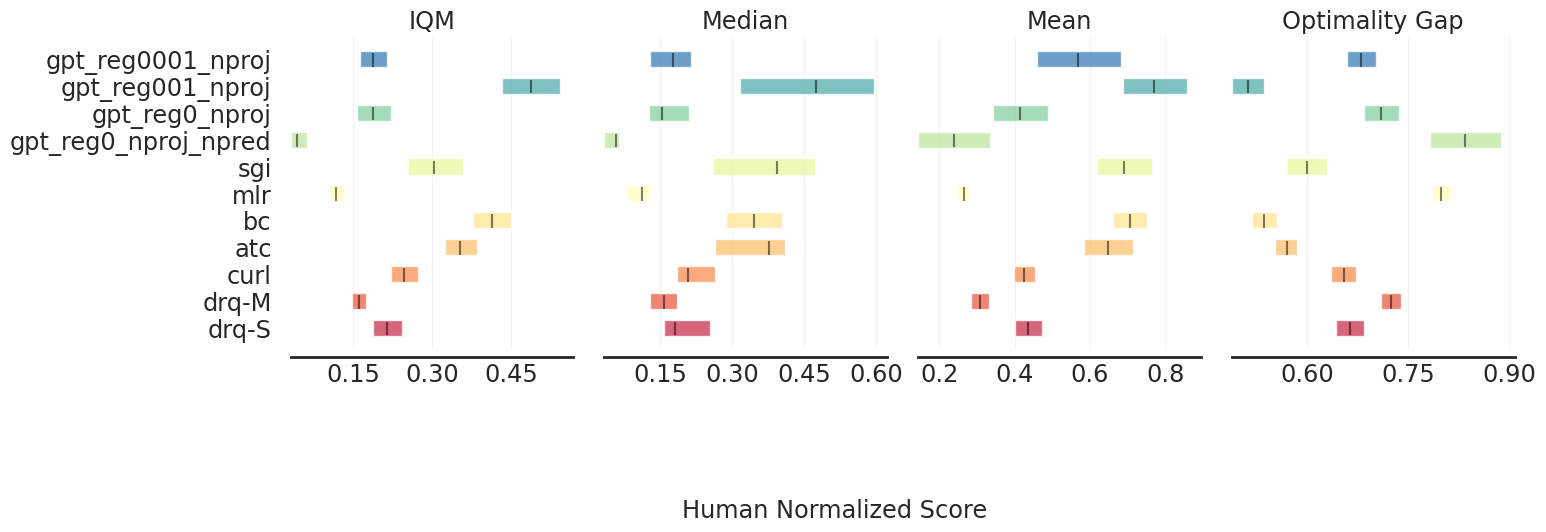

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'H', 'I', 'M', 'N', 'O', 'Q', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'hyphen', 'i', 'j', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 42, 43, 44, 48, 49, 50, 52, 54, 66, 68, 69, 70, 71, 72, 74, 76, 77, 79, 80, 81, 82, 83,

'atari_100k_aggregates.pdf'

In [20]:
algorithms = list(atari_exp_names.values())
ATARI_100K_COLOR_DICT = dict(zip(algorithms, [colors[idx] for idx in color_idxs]))

fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['IQM', 'Median', 'Mean', 'Optimality Gap'],
    algorithms=algorithms,
    colors=ATARI_100K_COLOR_DICT,
    xlabel_y_coordinate=-0.3,
    xlabel='Human Normalized Score')
#fig.tight_layout()
plt.show()
save_fig(fig, 'atari_100k_aggregates')